In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "meta-llama/Meta-Llama-3-8B"
# model_name = "Qwen/Qwen1.5-0.5B"
model_path = "results/amazon_polarity_title_only_weak_amplified/nw=499_no=0_m=Meta-Llama-3-8B_seq_sft/stage0/best-ckpt"
# model_path = "results/amazon_polarity_title_only_weak_amplified/nw=499_no=0_m=Qwen1.5-0.5B_seq_sft/stage0/best-ckpt"
base_model = AutoModelForSequenceClassification.from_pretrained(model_path).cuda()
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=1024)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
base_model.config.pad_token_id = tokenizer.pad_token_id  # type: ignore


/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
from peft import PeftConfig, PeftModel
from peft.tuners.lora.layer import LoraLayer
from w2s.model import AutoCastingScore
from transformers import AutoModelForSequenceClassification
import torch

base_model = base_model.to(torch.bfloat16)
base_model.score = AutoCastingScore(
    base_model.score, output_dtype=base_model.dtype
)
peft_config = PeftConfig.from_pretrained(model_path)
model = PeftModel.from_pretrained(base_model, model_path).train()

lora_params = [
    (*m.lora_A.parameters(), *m.lora_B.parameters())
    for m in model.modules()
    if isinstance(m, LoraLayer)
]
lora_params = [p for params in lora_params for p in params]
for p in lora_params:
    p.requires_grad_()

counter = 0
for p in model.parameters():
    if p.requires_grad:
        counter += 1
        p.data = p.data.float()

counter

449

In [3]:
from datasets import load_from_disk
# load the weak_amplified dataset
train_path = "/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only_weak_amplified/weak_train"
train_ds = load_from_disk(train_path).with_format("torch")
test_path = "/mnt/ssd-1/alexm/w2s/results/amazon_polarity_title_only_weak_amplified/weak_test"
test_ds = load_from_disk(test_path).with_format("torch")

In [4]:
from sklearn.metrics import roc_auc_score, accuracy_score

def get_labs(ds, conf_thresh=0.9):
    wsl = ds["soft_pred"][:, 1]
    whl = (wsl > 0.5).float()
    gt = ds["soft_label"][:, 1]
    disagree_idxs = (whl != gt).nonzero()
    wcl = (wsl > conf_thresh).float()
    wcl[((1 - conf_thresh) < wsl) & (wsl < conf_thresh)] = 0.5
    conf_disagree_idxs = (wcl == (1 - gt)).nonzero()
    return wsl, whl, gt, disagree_idxs, conf_disagree_idxs

train_wsl, train_whl, train_gt, train_disagree_idxs, train_conf_disagree_idxs = get_labs(train_ds)
test_wsl, test_whl, test_gt, test_disagree_idxs, test_conf_disagree_idxs = get_labs(test_ds)

In [5]:
disagreeing_test_ds = test_ds.select(test_conf_disagree_idxs)

In [43]:
import torch
from tqdm import tqdm
import numpy as np


# evaluate the model on n examples from disagreeing_test_ds
n = min(300, len(disagreeing_test_ds))
eval_ds = disagreeing_test_ds.shuffle(seed=42).select(range(n))
len(eval_ds), eval_ds[:10]

(179,
 {'label': tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 0]),
  'title': ['Cheap, in more ways than one...',
   'Wrong Color',
   'Screwed over by Amazon',
   'Interesting',
   'helps with the belly...',
   'To the reader from Coral Springs',
   'Lives up to its title',
   'Under rated series',
   'Moore stays true to himself!',
   'Great Voice'],
  'content': ['I was so happy to get this small keyboard and was ready to order another until I tried to use it. Within 10 minutes I was frustrated undoing unintentional typos, put it back in the box, and intend to get a refund.',
   'I bibs fit great. And they look good too. I haven\'t worn them outside yet. The picture shows the bibs as gray, the ones that came in the mail were black. I\'m 5\'4" and 135 pounds, I ordered the medium size and the fit is really comfortable.',
   "The item was perfect, just not what I ordered or wanted. Amazon says I ordered the wrong item and I had to pay return shipping and a re-stocking charge. I sent Amazon a co

In [12]:
model.eval()
model_probs = []

with torch.no_grad():
    for text in tqdm(eval_ds["txt"], desc="Evaluating"):
        inputs = tokenizer(text, return_tensors="pt", padding=False, truncation=True).to("cuda")
        
        outputs = model(**inputs)
        
        probs = torch.sigmoid(outputs.logits.diff(dim=-1))
        
        probs = probs.float().cpu().numpy()
        model_probs.extend(probs)
        
probs = np.array(model_probs)
print(f"Evaluation completed. Shape of model_probs: {probs.shape}")


Evaluating: 100%|██████████| 179/179 [00:10<00:00, 17.65it/s]

Evaluation completed. Shape of model_probs: (179, 1)


Accuracy: 0.7318, AUC: 0.4238, GT mean: 0.1676, probs mean: 0.1056, preds mean: 0.1117


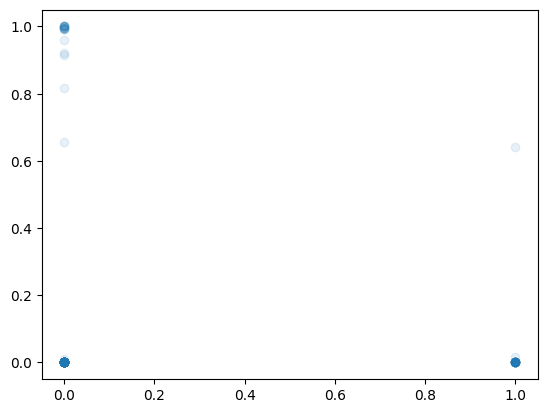

In [13]:
import matplotlib.pyplot as plt

eval_gt = eval_ds["soft_label"][:, 1]
eval_weak = eval_ds["soft_pred"][:, 1]
acc, auc = accuracy_score(eval_gt, probs > 0.5), roc_auc_score(eval_gt, probs)
print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}, GT mean: {eval_gt.mean():.4f}, probs mean: {probs.mean():.4f}, preds mean: {(probs > 0.5).mean():.4f}")

plt.scatter(eval_gt, probs, alpha=0.1)
plt.show()

(array([ 30.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 149.]),
 array([0.03258974, 0.12853697, 0.22448419, 0.32043141, 0.41637865,
        0.51232588, 0.60827309, 0.70422029, 0.8001675 , 0.89611477,
        0.99206197]),
 <BarContainer object of 10 artists>)

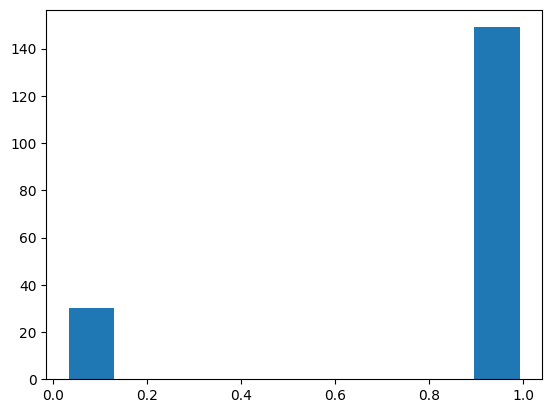

In [9]:
plt.hist(eval_weak)

In [10]:
model.config.pad_token_id = tokenizer.pad_token_id  # type: ignore

In [45]:
import random
seed = random.randint(0, 1000)
disambig_train_ds = train_ds.select(train_disagree_idxs).shuffle(seed=seed).select(range(n))
disambig_train_ds[:10]

{'label': tensor([0, 0, 1, 1, 1, 0, 1, 0, 0, 0]),
 'title': ['1990\'s characters in a "historical" setting',
  'IRON SUCKS',
  "Couldn't think of a title either.",
  'VHS Replacement',
  'I hate to be the spoiler, but....',
  'Seemed like a good design at the time',
  'Oil rig blast anybody?',
  'catch 22',
  'Noble but a Bit Limp',
  'Potty Humor In A Christmas Cash-In'],
 'content': ['For the life of me, I can\'t see why so many people liked this book (which is why I read it in the first place). The author and characters are SO out of place with their times; the proto-lesbian relationship, the omnipotent secret-police NKVD Home Guard units, the goofy protagonist.The author\'s writing style is warmed-over Cormack McCarthy. I know it\'s his first book, which is why I didn\'t give it 1 star, but it is not an impressive first effort.All I can figure is that this would be considered "great literature" by people who mostly read "bodice rippers" and are members of Oprah\'s book club.',
  "I

In [46]:
from w2s.sft import lm_sft
from w2s.utils import ds_with_labels
from w2s.sft_config import set_default_args
from transformers import TrainingArguments
from datasets import DatasetDict
from pathlib import Path

n = 10
train_args = set_default_args(
    args={
        "num_train_epochs": 50,
        "output_dir": Path(model_path).parent.parent / f"10sample_{seed}",
        "per_device_train_batch_size": 1,
        "gradient_accumulation_steps": 32,
        "per_device_eval_batch_size": 1,
    },
    model_name=model_name,
    run_name="10sample.ipynb"
)
ddict = DatasetDict(
    train=ds_with_labels(disambig_train_ds.with_format("python"), labels_column="soft_label"),
    test=ds_with_labels(eval_ds.with_format("python"), labels_column="soft_label")
)
model.train()
lm_sft(
    ddict,
    model,
    tokenizer,
    TrainingArguments(**train_args),
    loss="xent",
    cfg={"notebook": "10sample.ipynb"},
    store_pre_hiddens=False,
    store_post_hiddens=False
)
    

Flattening the indices: 100%|██████████| 179/179 [00:00<00:00, 23862.33 examples/s]


torch.cuda.memory_allocated: 14.72GB
6.37% of all GPU memory in use before training


Map: 100%|██████████| 179/179 [00:00<00:00, 7645.66 examples/s]


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [47]:
ddict['train'].features['soft_label'].value_counts()

AttributeError: 'Sequence' object has no attribute 'value_counts'